### Setup

In [1]:
import os
import gzip
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.style as style
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes

### Load Data

In [2]:
# define directory for data files
p = r'C:\Users\alex\Desktop\Cass\Term_1\SMM635 Data Visualisation\Project\Midterm'

In [3]:
# define function for unzipping a file into a data frame
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [4]:
# upload first dataset (cell) and metadata into dataframe
f0 = 'ratings_Cell_Phones_and_Accessories.csv'
f00 = 'meta_Cell_Phones_and_Accessories.json.gz'

# create a path to datasets
pathdata0 = os.path.join(p,f0)
pathmeta0 = os.path.join(p,f00)

cell = pd.read_csv(pathdata0, names=['user', 'product_id', 'rating', 'timestamp'])
cell['review_date'] = pd.to_datetime(cell['timestamp'], unit = 's', errors = 'coerce')
cell.drop(columns={'timestamp'}, inplace=True)
cellmeta = getDF(pathmeta0)

In [5]:
# upload second dataset (Digital Music) and metadata into dataframe
f1 = 'ratings_Digital_Music.csv'
f11 = 'meta_Digital_Music.json.gz'

pathdata1 = os.path.join(p,f1)
pathmeta1 = os.path.join(p,f11)

dig = pd.read_csv(pathdata1, names=['user', 'product_id', 'rating', 'timestamp'])
dig['review_date'] = pd.to_datetime(dig['timestamp'], unit = 's', errors = 'coerce')
dig.drop(columns={'timestamp'}, inplace=True)
digmeta = getDF(pathmeta1)

In [6]:
# upload third dataset (Toys & Games) and metadata into dataframe
f2 = 'ratings_Toys_and_Games.csv'
f22 = 'meta_Toys_and_Games.json.gz'

pathdata2 = os.path.join(p,f2)
pathmeta2 = os.path.join(p,f22)

toys = pd.read_csv(pathdata2, names=['user', 'product_id', 'rating', 'timestamp'])
toys['review_date'] = pd.to_datetime(toys['timestamp'], unit = 's', errors = 'coerce')
toys.drop(columns={'timestamp'}, inplace=True)
toysmeta = getDF(pathmeta2)

### Preparing the datasets

#### Metadatasets

##### Drop null values from metadata

In [7]:
# drop null values from price row
cellmeta.dropna(subset=['price'], inplace=True)

In [8]:
digmeta.dropna(subset=['price'], inplace=True)

In [9]:
toysmeta.dropna(subset=['price'], inplace=True)

##### Ratings datatsets

###### cell

In [10]:
# filtering out products launched less than 6 months ago
cell.loc[:,'first_review'] = cell.groupby('product_id')['review_date'].transform(np.min)
cell.loc[:,'last_review'] = cell.groupby('product_id')['review_date'].transform(np.max)
cell.loc[:,'delta_days'] = (cell['review_date']-cell['first_review']).dt.days
cell.loc[:,'year_review_date']=cell['review_date'].dt.year
cell.loc[:,'year_first_review']=cell['first_review'].dt.year

In [11]:
# check the variable 'first_review', wheter it works properly
# if there are no data in check_function then it works
check_function = cell.loc[(cell['delta_days'] <0)]
check_function.head()

,user,product_id,rating,review_date,first_review,last_review,delta_days,year_review_date,year_first_review


In [12]:
cell = cell.sort_values(['product_id', 'review_date'])

cell.loc[:, 'count'] = 1

gr19 = cell.groupby('product_id')['count']

cell.loc[:, 'cum-sum'] = gr19.transform(np.cumsum)

cell.head()

,user,product_id,rating,review_date,first_review,last_review,delta_days,year_review_date,year_first_review,count,cum-sum
0,A1EWN6KZ4HMLT7,011040047X,1.0,2012-08-14,2012-08-14,2012-08-14,0,2012,2012,1,1
12,A2UCUB1VC1SDJK,0110400550,5.0,2012-07-14,2012-07-14,2014-07-06,0,2012,2012,1,1
17,A14C9GGECI06HU,0110400550,5.0,2012-08-19,2012-07-14,2014-07-06,36,2012,2012,1,2
25,A3T8C0H9LOB1FS,0110400550,3.0,2012-11-04,2012-07-14,2014-07-06,113,2012,2012,1,3
16,A2HL78OBL9UYRE,0110400550,1.0,2012-11-12,2012-07-14,2014-07-06,121,2012,2012,1,4


In [13]:
conditions_cell = [
    ((cell['delta_days'] == 0) & (cell['cum-sum'] == 1)),
    ((cell['delta_days'] == 0) & (cell['cum-sum'] > 1)) | (((cell['delta_days'] > 0) & (cell['delta_days'] <= 30)) & (cell['cum-sum'] > 1)),
    ((cell['delta_days'] > 30) & (cell['delta_days'] <= 60) & (cell['cum-sum'] > 1)),
    ((cell['delta_days'] > 60) & (cell['delta_days'] <= 90) & (cell['cum-sum'] > 1)),
    ((cell['delta_days'] > 90) & (cell['delta_days'] <= 120) & (cell['cum-sum'] > 1)),
    ((cell['delta_days'] > 120) & (cell['delta_days'] <= 150) & (cell['cum-sum'] > 1)),
    ((cell['delta_days'] > 150) & (cell['cum-sum'] > 1))]

month_ticks = np.arange(0,7)

cell['month'] = np.select(conditions_cell, month_ticks, default = 0)
cell.loc[:,'category']='cell'

cell.head()

,user,product_id,rating,review_date,first_review,last_review,delta_days,year_review_date,year_first_review,count,cum-sum,month,category
0,A1EWN6KZ4HMLT7,011040047X,1.0,2012-08-14,2012-08-14,2012-08-14,0,2012,2012,1,1,0,cell
12,A2UCUB1VC1SDJK,0110400550,5.0,2012-07-14,2012-07-14,2014-07-06,0,2012,2012,1,1,0,cell
17,A14C9GGECI06HU,0110400550,5.0,2012-08-19,2012-07-14,2014-07-06,36,2012,2012,1,2,2,cell
25,A3T8C0H9LOB1FS,0110400550,3.0,2012-11-04,2012-07-14,2014-07-06,113,2012,2012,1,3,4,cell
16,A2HL78OBL9UYRE,0110400550,1.0,2012-11-12,2012-07-14,2014-07-06,121,2012,2012,1,4,5,cell


In [14]:
cell.drop(['count', 'cum-sum'], axis=1, inplace=True)

In [15]:
# only keeping data within 6 months after launch
cell = cell[cell['delta_days'] < 182]

In [16]:
# filtering out products launched less than 6 months ago
cell = cell[cell['review_date'] < (cell['review_date'].max()-dt.timedelta(days=182))]
cell.head()

,user,product_id,rating,review_date,first_review,last_review,delta_days,year_review_date,year_first_review,month,category
0,A1EWN6KZ4HMLT7,011040047X,1.0,2012-08-14,2012-08-14,2012-08-14,0,2012,2012,0,cell
12,A2UCUB1VC1SDJK,0110400550,5.0,2012-07-14,2012-07-14,2014-07-06,0,2012,2012,0,cell
17,A14C9GGECI06HU,0110400550,5.0,2012-08-19,2012-07-14,2014-07-06,36,2012,2012,2,cell
25,A3T8C0H9LOB1FS,0110400550,3.0,2012-11-04,2012-07-14,2014-07-06,113,2012,2012,4,cell
16,A2HL78OBL9UYRE,0110400550,1.0,2012-11-12,2012-07-14,2014-07-06,121,2012,2012,5,cell


###### dig

In [17]:
dig.loc[:,'first_review'] = dig.groupby('product_id')['review_date'].transform(np.min)
dig.loc[:,'last_review'] = dig.groupby('product_id')['review_date'].transform(np.max)
dig.loc[:,'delta_days'] = (dig['review_date']-dig['first_review']).dt.days
dig.loc[:,'year_review_date']=dig['review_date'].dt.year
dig.loc[:,'year_first_review']=dig['first_review'].dt.year

In [18]:
dig = dig.sort_values(['product_id', 'review_date'])
dig.loc[:, 'count'] = 1
gr20 = dig.groupby('product_id')['count']
dig.loc[:, 'cum-sum'] = gr20.transform(np.cumsum)

In [19]:
conditions_dig = [
    ((dig['delta_days'] == 0) & (dig['cum-sum'] == 1)),
    ((dig['delta_days'] == 0) & (dig['cum-sum'] > 1)) | (((dig['delta_days'] > 0) & (dig['delta_days'] <= 30)) & (dig['cum-sum'] > 1)),
    ((dig['delta_days'] > 30) & (dig['delta_days'] <= 60) & (dig['cum-sum'] > 1)),
    ((dig['delta_days'] > 60) & (dig['delta_days'] <= 90) & (dig['cum-sum'] > 1)),
    ((dig['delta_days'] > 90) & (dig['delta_days'] <= 120) & (dig['cum-sum'] > 1)),
    ((dig['delta_days'] > 120) & (dig['delta_days'] <= 150) & (dig['cum-sum'] > 1)),
    ((dig['delta_days'] > 150) & (dig['cum-sum'] > 1))]

month_ticks = np.arange(0,7)

dig['month'] = np.select(conditions_dig, month_ticks, default = 0)
dig.loc[:,'category']='dig'

dig.drop(['count', 'cum-sum'], axis=1, inplace=True)

In [20]:
dig = dig[dig['delta_days'] < 182]

In [21]:
dig = dig[dig['review_date'] < (dig['review_date'].max()-dt.timedelta(days=182))]

In [22]:
dig.head()

,user,product_id,rating,review_date,first_review,last_review,delta_days,year_review_date,year_first_review,month,category
76,AO8MTVRSM6Q34,5555991584,5.0,1998-06-20,1998-06-20,2014-07-04,0,1998,1998,0,dig
105,A2KBUZZB3HWV6C,5555991584,5.0,1998-10-02,1998-06-20,2014-07-04,104,1998,1998,4,dig
130,A1T1OG976WVRSG,6308051551,5.0,2004-02-27,2004-02-27,2004-12-01,0,2004,2004,0,dig
138,A1VM36YC8NP59I,7901622466,5.0,2004-10-13,2004-10-13,2014-04-14,0,2004,2004,0,dig
157,A2W3GJ7U82WTH1,B0000000ZW,5.0,1999-12-08,1999-12-08,2014-07-06,0,1999,1999,0,dig


###### toys

In [23]:
toys.loc[:,'first_review'] = toys.groupby('product_id')['review_date'].transform(np.min)
toys.loc[:,'last_review'] = toys.groupby('product_id')['review_date'].transform(np.max)
toys.loc[:,'delta_days'] = (toys['review_date']-toys['first_review']).dt.days
toys.loc[:,'year_review_date']=toys['review_date'].dt.year
toys.loc[:,'year_first_review']=toys['first_review'].dt.year

In [24]:
toys = toys.sort_values(['product_id', 'review_date'])
toys.loc[:, 'count'] = 1
gr21 = toys.groupby('product_id')['count']
toys.loc[:, 'cum-sum'] = gr21.transform(np.cumsum)

In [25]:
conditions_toys = [
    ((toys['delta_days'] == 0) & (toys['cum-sum'] == 1)),
    ((toys['delta_days'] == 0) & (toys['cum-sum'] > 1)) | (((toys['delta_days'] > 0) & (toys['delta_days'] <= 30)) & (toys['cum-sum'] > 1)),
    ((toys['delta_days'] > 30) & (toys['delta_days'] <= 60) & (toys['cum-sum'] > 1)),
    ((toys['delta_days'] > 60) & (toys['delta_days'] <= 90) & (toys['cum-sum'] > 1)),
    ((toys['delta_days'] > 90) & (toys['delta_days'] <= 120) & (toys['cum-sum'] > 1)),
    ((toys['delta_days'] > 120) & (toys['delta_days'] <= 150) & (toys['cum-sum'] > 1)),
    ((toys['delta_days'] > 150) & (toys['cum-sum'] > 1))]

month_ticks = np.arange(0,7)

toys['month'] = np.select(conditions_toys, month_ticks, default = 0)
toys.loc[:,'category']='toys'

toys.drop(['count', 'cum-sum'], axis=1, inplace=True)

In [26]:
toys = toys[toys['delta_days'] < 182]

In [27]:
toys = toys[toys['review_date'] < (toys['review_date'].max()-dt.timedelta(days=182))]

In [28]:
toys.head()

,user,product_id,rating,review_date,first_review,last_review,delta_days,year_review_date,year_first_review,month,category
0,AMEVO2LY6VEJA,0000191639,5.0,2013-12-26,2013-12-26,2013-12-26,0,2013,2013,0,toys
1,A3C9CSW3TJITGT,0005069491,4.0,2013-08-27,2013-08-27,2013-08-27,0,2013,2013,0,toys
3,A2GGHHME9B6W4O,0131358936,5.0,2013-10-22,2013-10-22,2013-10-22,0,2013,2013,0,toys
4,A1FSLDH43ORWZP,0133642984,5.0,2013-07-20,2013-07-20,2013-07-20,0,2013,2013,0,toys
5,A3NXHTSEBX9YHB,0279515766,5.0,2013-03-18,2013-03-18,2013-03-18,0,2013,2013,0,toys


## Plot 1

In [29]:
df = pd.concat([cell, dig, toys],sort=True)

In [30]:
# adding review count data
df.loc[:,'reviews']=1
df = df.loc[(df['year_first_review'] > 2010) & (df['year_first_review'] < 2014)]
df.head(1)

,category,delta_days,first_review,last_review,month,product_id,rating,review_date,user,year_first_review,year_review_date,reviews
0,cell,0,2012-08-14,2012-08-14,0,011040047X,1.0,2012-08-14,A1EWN6KZ4HMLT7,2012,2012,1


In [31]:
# new data frame grouped by date, with reviews in a month ditoysed by products reviewed that month
df1 = pd.DataFrame(df.groupby(['category','year_first_review','month']).count()['reviews']).reset_index()
df1.loc[:,'products'] = (pd.DataFrame(df.groupby(['category','year_first_review','month'])['product_id'].nunique()).reset_index())['product_id']
df1.loc[:,'reviews/product'] = df1['reviews']/df1['products']
df1.loc[:,'year_total_reviews'] = ((df1.groupby(['category','year_first_review'])['reviews'].transform(np.sum))/100000).round(1)
df1.loc[:,'year_total_products'] = ((df1.groupby(['category','year_first_review'])['products'].transform(np.sum))/100000).round(1)
df1.head()

,category,year_first_review,month,reviews,products,reviews/product,year_total_reviews,year_total_products
0,cell,2011,0,34291,34291,1.000000,1.2,0.7
1,cell,2011,1,14721,6566,2.242004,1.2,0.7
2,cell,2011,2,15201,6350,2.393858,1.2,0.7
3,cell,2011,3,15139,6126,2.471270,1.2,0.7
4,cell,2011,4,14568,5968,2.441019,1.2,0.7


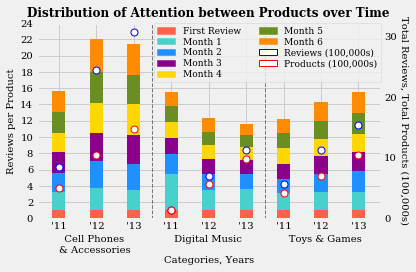

In [32]:
# stacked bar chart
style.use('fivethirtyeight')

fig, ax1 = plt.subplots(1)

N = np.dot([df1['category'].nunique()],[df1['year_first_review'].nunique()])    # N = number of categories = 3 categories over 3 years
M = df1['month'].nunique()    # M = number of months from first review
categories = list(df['category'].unique())    # categories = unique product categories

# reviews/product per month data
monthcat = []     # list of values for each month as a categorical variable
for i in np.arange(M):
    for j in categories:
        for z in np.arange(2011,2014):
            m = np.array([(df1[(df1['category']==j) & (df1['month']==i) & (df1['year_first_review']==z)]['reviews/product'].values)])
            monthcat.append(m)
monthcat = np.concatenate(monthcat)
monthcat.resize(7,9)

# plot params
ind = np.arange(N)    # the x locations for the groups
w = 0.35       # the width of the bars: can also be len(x) sequence
bottom = 0     # null bottom bar
colors = ['tomato','mediumturquoise','dodgerblue','darkmagenta','gold','olivedrab','darkorange']

#plotting average reviews per product
for i in np.arange(M):
    if i == 0:
        plt.bar(ind, monthcat[0], width=w, color=colors[i])
    else:
        bottom+= monthcat[i-1]
        plt.bar(ind, monthcat[i], width=w, color=colors[i],
             bottom=bottom)

# font params
rcParams['font.family'] = 'serif'
font_ax = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 10,
        }
font_t = {'family': 'serif',
        'color':  'k',
        'weight': 'bold',
        'size': 12,
        }
# title, labels, ticks
plt.axvline(x=2.5, ymin=0, ymax=22, linestyle='--', linewidth=1, color='k', alpha=0.5)
plt.axvline(x=5.5, ymin=0, ymax=22, linestyle='--', linewidth=1, color='k', alpha=0.5)

plt.ylabel('Reviews per Product', fontdict=font_ax)
plt.xlabel('   Cell Phones                Digital Music               Toys & Games\n& Accessories                                                                         \nCategories, Years', fontdict=font_ax)
plt.title('Distribution of Attention between Products over Time', fontdict=font_t)

xticks = ['\'11','\'12','\'13']*3
plt.xticks(ind,xticks)
plt.setp(ax1.get_yticklabels(), fontsize=10, family='serif')
plt.setp(ax1.get_xticklabels(), fontsize=10, family='serif')
plt.yticks(list(np.arange(0, 26, 2)))

# year total data
ax2 = ax1.twinx()
plt.ylabel('Total Reviews, Total Products (100,000s)', fontdict=font_ax, rotation=270, labelpad=12)
ax2.grid(b=False)
plt.setp(ax2.get_yticklabels(), fontsize=10, family='serif')
plt.yscale('linear')

#total reviews count
ylist1 = []
for i in categories:
    for j in np.arange(2011,2014):
        y = (df1[(df1['category']==i) & (df1['year_first_review']==j)]['year_total_reviews'].aggregate(np.sum).round(3))
        ylist1.append(y)
plt.plot(ind,ylist1,linewidth=0,marker='o',markersize=7, markeredgecolor='b',color='w')

# total products count
ylist2 = []
for i in categories:
    for j in np.arange(2011,2014):
        y = (df1[(df1['category']==i) & (df1['year_first_review']==j)]['year_total_products'].aggregate(np.sum).round(3))
        ylist2.append(y)
plt.plot(ind,ylist2,linewidth=0,marker='o',markersize=7, markeredgecolor='r',color='w')

# legend params
patchlist=[]
for i in np.arange(M):
    if i == 0:
        patch=mpatches.Patch(color=colors[i], label=('First Review'))
        patchlist.append(patch)
    else:
        patch=mpatches.Patch(color=colors[i], label=(str('Month ')+str(i)))
        patchlist.append(patch)
c1 = mpatches.Circle((0.5, 0.5), 0.25, label='Reviews (100,000s)', facecolor='w',
                    edgecolor='b', linewidth=1)
patchlist.append(c1)
c2 = mpatches.Circle((0.5, 0.5), 0.25, label='Products (100,000s)', facecolor='w',
                    edgecolor='r', linewidth=1)
patchlist.append(c2)
plt.legend(handles=patchlist, ncol=2, borderaxespad=0, fontsize=9, labelspacing=0.2)

# show plot
plt.tight_layout()
plt.savefig('plot1.png')
plt.show()
plt.close()

## Plot 2.
Reviews/Product ~ 6 Months (3 Years)

In [33]:
# cell
cell_plt1 = cell.copy(deep=True)

In [34]:
# toys
toys_plt1 = toys.copy(deep=True)

In [35]:
# digital music
dig_plt1 = dig.copy(deep=True)

#### Filtering dates

In [36]:
toys_plt1 = toys_plt1.loc[(toys_plt1['year_first_review'] > 2010) & (toys_plt1['year_first_review'] < 2014)]
dig_plt1 = dig_plt1.loc[(dig_plt1['year_first_review'] > 2010) & (dig_plt1['year_first_review'] < 2014)]
cell_plt1 = cell_plt1.loc[(cell_plt1['year_first_review'] > 2010) & (cell_plt1['year_first_review'] < 2014)]

#### Groupped dataset

In [37]:
df_plt1_merge = pd.concat([toys_plt1, dig_plt1, cell_plt1], sort='True')
df_plt1_merge.loc[:,'reviews']=1

In [38]:
df_plt1_merge1 = pd.DataFrame(df_plt1_merge.groupby(['year_first_review', 'month', 'category']).count()['reviews']).reset_index()

In [39]:
df_plt1_merge1.loc[:,'products'] = (pd.DataFrame(df_plt1_merge.groupby(['year_first_review', 'month', 'category'])['product_id'].nunique()).reset_index())['product_id']

df_plt1_merge1.loc[:,'reviews/product'] = df_plt1_merge1['reviews']/df_plt1_merge1['products']
df_plt1_merge1

,year_first_review,month,category,reviews,products,reviews/product
0,2011,0,cell,34291,34291,1.000000
1,2011,0,dig,13926,13926,1.000000
2,2011,0,toys,36928,36928,1.000000
3,2011,1,cell,14721,6566,2.242004
4,2011,1,dig,5633,1277,4.411120
5,2011,1,toys,9751,4640,2.101509
6,2011,2,cell,15201,6350,2.393858
7,2011,2,dig,1563,622,2.512862
8,2011,2,toys,6971,3886,1.793875
9,2011,3,cell,15139,6126,2.471270


In [40]:
df_plt1_merge1.drop(['reviews', 'products'], axis=1, inplace=True)

In [41]:
df_plt1_final=df_plt1_merge1.pivot_table(index=['year_first_review','month'], columns='category',values='reviews/product')
df_plt1_final.reset_index(inplace=True)
df_plt1_final

category,year_first_review,month,cell,dig,toys
0,2011,0,1.000000,1.000000,1.000000
1,2011,1,2.242004,4.411120,2.101509
2,2011,2,2.393858,2.512862,1.793875
3,2011,3,2.471270,1.929825,1.750485
4,2011,4,2.441019,2.017897,1.953589
5,2011,5,2.482747,1.927083,1.892413
6,2011,6,2.597871,1.752969,1.714198
7,2012,0,1.000000,1.000000,1.000000
8,2012,1,2.803202,2.472930,2.264508
9,2012,2,3.215863,1.953469,2.225578


In [42]:
# calculating month-on-month % change in reviews per product
gr000 = df_plt1_final.groupby('year_first_review')

df_plt1_final.loc[:,'cell_t-1']= gr000['cell'].shift(1)
df_plt1_final.loc[:,'toys_t-1']= gr000['toys'].shift(1)
df_plt1_final.loc[:,'dig_t-1']= gr000['dig'].shift(1)

df_plt1_final.loc[:, '% change cell'] = ((df_plt1_final['cell'] - df_plt1_final['cell_t-1']) / df_plt1_final['cell_t-1'])*100
df_plt1_final.loc[:, '% change toys'] = ((df_plt1_final['toys'] - df_plt1_final['toys_t-1']) / df_plt1_final['toys_t-1'])*100
df_plt1_final.loc[:, '% change dig'] = ((df_plt1_final['dig'] - df_plt1_final['dig_t-1']) / df_plt1_final['dig_t-1'])*100

df_plt1_final.drop(columns=['cell_t-1', 'toys_t-1', 'dig_t-1'], axis=1)

df_plt1_final

category,year_first_review,month,cell,dig,toys,cell_t-1,toys_t-1,dig_t-1,% change cell,% change toys,% change dig
0,2011,0,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,1,2.242004,4.411120,2.101509,1.000000,1.000000,1.000000,124.200426,110.150862,341.111981
2,2011,2,2.393858,2.512862,1.793875,2.242004,2.101509,4.411120,6.773136,-14.638682,-43.033474
3,2011,3,2.471270,1.929825,1.750485,2.393858,1.793875,2.512862,3.233764,-2.418801,-23.202119
4,2011,4,2.441019,2.017897,1.953589,2.471270,1.750485,1.929825,-1.224117,11.602713,4.563758
5,2011,5,2.482747,1.927083,1.892413,2.441019,1.953589,2.017897,1.709448,-3.131486,-4.500416
6,2011,6,2.597871,1.752969,1.714198,2.482747,1.892413,1.927083,4.636967,-9.417316,-9.035116
7,2012,0,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
8,2012,1,2.803202,2.472930,2.264508,1.000000,1.000000,1.000000,180.320199,126.450789,147.293032
9,2012,2,3.215863,1.953469,2.225578,2.803202,2.264508,2.472930,14.721075,-1.719125,-21.005896


In [43]:
for i in list(['% change cell','% change toys','% change dig']):
    df_plt1_final.loc[df_plt1_final.month==1,[i]] = np.nan
df_plt1_final

category,year_first_review,month,cell,dig,toys,cell_t-1,toys_t-1,dig_t-1,% change cell,% change toys,% change dig
0,2011,0,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,1,2.242004,4.411120,2.101509,1.000000,1.000000,1.000000,NaN,NaN,NaN
2,2011,2,2.393858,2.512862,1.793875,2.242004,2.101509,4.411120,6.773136,-14.638682,-43.033474
3,2011,3,2.471270,1.929825,1.750485,2.393858,1.793875,2.512862,3.233764,-2.418801,-23.202119
4,2011,4,2.441019,2.017897,1.953589,2.471270,1.750485,1.929825,-1.224117,11.602713,4.563758
5,2011,5,2.482747,1.927083,1.892413,2.441019,1.953589,2.017897,1.709448,-3.131486,-4.500416
6,2011,6,2.597871,1.752969,1.714198,2.482747,1.892413,1.927083,4.636967,-9.417316,-9.035116
7,2012,0,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
8,2012,1,2.803202,2.472930,2.264508,1.000000,1.000000,1.000000,NaN,NaN,NaN
9,2012,2,3.215863,1.953469,2.225578,2.803202,2.264508,2.472930,14.721075,-1.719125,-21.005896


### Plot 2

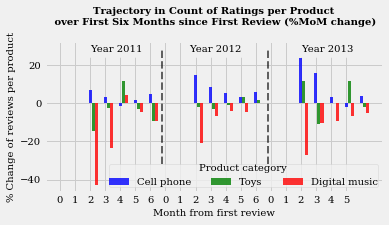

In [45]:
style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=tuple(np.dot(0.5,[11.27,6.69])))

index = np.arange(1,22,1)
bar_width = 0.2
bar_width1 = 0.4
opacity = 0.8

plt.vlines(7.8,-32,29,color = 'k', linestyles = 'dashed', linewidth=2, alpha=0.6)
plt.vlines(14.8,-32,29,color = 'k', linestyles = 'dashed', linewidth=2, alpha=0.6)

plt.bar(index, df_plt1_final['% change cell'], bar_width,
alpha=opacity,
color='b',
label='Cell phone')

plt.bar(index + bar_width, df_plt1_final['% change toys'], bar_width,
alpha=opacity,
color='g',
label='Toys')

plt.bar(index + bar_width1, df_plt1_final['% change dig'], bar_width,
alpha=opacity,
color='r',
label='Digital music')

x = np.arange(len(df_plt1_final['month']))

plt.xticks(x, ['', '0', '1', '2', '3', '4', '5', '6', '0', '1', '2', '3', '4', '5', '6', '0', '1', '2', '3', '4', '5', '6'])
plt.setp(ax.get_yticklabels(), fontsize=10, family='serif')
plt.setp(ax.get_xticklabels(), fontsize=10, family='serif')
plt.xlabel('Month from first review', fontsize=10)
plt.ylabel("% Change of reviews per product", fontsize=10)
plt.title('Trajectory in Count of Ratings per Product\n over First Six Months since First Review (%MoM change)\n', weight='bold', fontsize=10)

ax.legend(fontsize=10, ncol=3,loc='lower right', borderpad=0).set_title('Product category', prop={"size": 10})
plt.text(x=3, y=27, s='Year 2011', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=9.6, y=27, s='Year 2012', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=17, y=27, s='Year 2013', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

# show plot
plt.tight_layout()
plt.savefig('plot2.png')
plt.show()
plt.close()

## Plot 3

### toys

In [46]:
toysmeta.rename(columns={'asin':'product_id'}, inplace=True)
toys_merge = toys.merge(toysmeta, on='product_id', how='left').sort_values(['price'], ascending=True)

In [47]:
toys_merge.dropna(subset=['price'], inplace=True)

In [48]:
toys_merge.loc[:,'price range']=pd.qcut(x=(toys_merge['price']),q=4,labels=('<25%', '25-50%', '50-75%', '>75%'))

### dig

In [49]:
digmeta.rename(columns={'asin':'product_id'}, inplace=True)
dig_merge = dig.merge(digmeta, on='product_id', how='left').sort_values(['price'], ascending=True)
dig_merge.dropna(subset=['price'], inplace=True, axis=0)

In [50]:
dig_merge.loc[:,'price range']=pd.qcut(x=(dig_merge['price']),q=4,labels=('<25%', '25-50%', '50-75%', '>75%'))

### cell

In [51]:
cellmeta.rename(columns={'asin':'product_id'}, inplace=True)
cell_merge = cell.merge(cellmeta, on='product_id', how='left').sort_values(['price'], ascending=True)

In [52]:
cell_merge.dropna(subset=['price'], inplace=True)

In [53]:
cell_merge.loc[:,'price range']=pd.qcut(x=(cell_merge['price']),q=4,labels=('<25%', '25-50%', '50-75%', '>75%'))

### Filtering the year

In [54]:
toys_merge = toys_merge.loc[(toys_merge['year_first_review'] == 2013)]
dig_merge = dig_merge.loc[(dig_merge['year_first_review'] == 2013)]
cell_merge = cell_merge.loc[(cell_merge['year_first_review'] == 2013)]

### Grouped

In [55]:
df_merge = pd.concat([cell_merge, dig_merge, toys_merge], sort='True')
df_merge.loc[:,'reviews']=1

In [56]:
df_merge2 = pd.DataFrame(df_merge.groupby(['category', 'month', 'price range']).count()['reviews']).reset_index()
df_merge2 = df_merge2.loc[(df_merge2['price range'] != '0')]

In [57]:
months = list(np.arange(0,21))*4
months.sort()

In [58]:
df_merge2.loc[:,'month']=months
df_merge2.head()

,category,month,price range,reviews
0,cell,0,<25%,30827
1,cell,0,25-50%,30912
2,cell,0,50-75%,25328
3,cell,0,>75%,13094
4,cell,1,<25%,10646


In [59]:
df_merge2.loc[:, 'cumulative sum of reviews'] = (df_merge2.groupby('month')['reviews']).transform(np.cumsum)
df_gr = pd.DataFrame(df_merge2.groupby('month')['cumulative sum of reviews'].max())
df_merge2 = df_merge2.merge(df_gr, on='month', how='left')

In [60]:
df_merge2.rename(columns={'cumulative sum of reviews_y':'cumulative sum of reviews'}, inplace=True)
df_merge2['% reviews'] = (df_merge2['reviews']/df_merge2['cumulative sum of reviews'])*100
df_merge2 = df_merge2.drop(['category', 'reviews', 'cumulative sum of reviews', 'cumulative sum of reviews_x'], axis=1)

In [61]:
df_merge2.tail()

,month,price range,% reviews
79,19,>75%,24.965175
80,20,<25%,21.154389
81,20,25-50%,26.764042
82,20,50-75%,28.803274
83,20,>75%,23.278295


In [62]:
df_merge2_final=df_merge2.pivot_table(index='month', columns='price range', values='% reviews')
df_merge2_final = df_merge2_final.rename(columns=str).reset_index()
df_merge2_final.columns=['months','cheapest', '25-50% quan.', '50-75% quan.', 'most expensive']
df_merge2_final

,months,cheapest,25-50% quan.,50-75% quan.,most expensive
0,0,30.777448,30.862312,25.287287,13.072953
1,1,19.144383,26.026363,29.000701,25.828553
2,2,18.241839,26.599418,29.796656,25.362087
3,3,17.499880,25.835211,29.575485,27.089425
4,4,18.746855,25.988284,27.438367,27.826493
5,5,20.355856,25.846523,26.429429,27.368191
6,6,20.811322,25.524645,26.098968,27.565066
7,7,71.599324,6.021827,20.335845,2.043004
8,8,63.600000,5.108197,15.049180,16.242623
9,9,66.862135,4.499761,15.234562,13.403542


In [63]:
# Just for visualization purposes

# Function to insert row in the dataframe 
def Insert_row_(row_number, df_merge2_final, row_value): 
    # Slice the upper half of the dataframe 
    df1 = df_merge2_final[0:row_number] 
   
    # Store the result of lower half of the dataframe 
    df2 = df_merge2_final[row_number:] 
   
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
   
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
   
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 
   
# Let's create a row which we want to insert 
row_number = 7
row_value = [21, 0, 0, 0, 0] # months 21 and 22
  
if row_number > df_merge2_final.index.max()+1: 
    print("Invalid row_number") 
else: 
  
    # Let's call the function and insert the row 
    # at the 7 and 15 position 
    df_merge2_final = Insert_row_(7, df_merge2_final, row_value) 
    
# And again
# Function to insert row in the dataframe 
def Insert_row_1(row_number1, df_merge2_final, row_value1): 
    # Slice the upper half of the dataframe 
    df1 = df_merge2_final[0:row_number1] 
   
    # Store the result of lower half of the dataframe 
    df2 = df_merge2_final[row_number1:] 
   
    # Inser the row in the upper half dataframe 
    df1.loc[row_number1]=row_value1 
   
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
   
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 
   
# Let's create a row which we want to insert 
row_number1 = 15
row_value1 = [22, 0, 0, 0, 0] # months 21 and 22
  
if row_number1 > df_merge2_final.index.max()+1: 
    print("Invalid row_number1") 
else: 
  
    # Let's call the function and insert the row 
    # at the 7 and 15 position 
    df_merge2_final = Insert_row_1(15, df_merge2_final, row_value1) 
  
    # Print the updated dataframe 
    print(df_merge2_final)

C:\Users\dsimu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


    months   cheapest  25-50% quan.  50-75% quan.  most expensive
0        0  30.777448     30.862312     25.287287       13.072953
1        1  19.144383     26.026363     29.000701       25.828553
2        2  18.241839     26.599418     29.796656       25.362087
3        3  17.499880     25.835211     29.575485       27.089425
4        4  18.746855     25.988284     27.438367       27.826493
5        5  20.355856     25.846523     26.429429       27.368191
6        6  20.811322     25.524645     26.098968       27.565066
7       21   0.000000      0.000000      0.000000        0.000000
8        7  71.599324      6.021827     20.335845        2.043004
9        8  63.600000      5.108197     15.049180       16.242623
10       9  66.862135      4.499761     15.234562       13.403542
11      10  70.593150      5.547201     14.118630        9.741019
12      11  73.064735      4.323223     14.101403        8.510638
13      12  73.999407      4.595316     13.904536        7.500741
14      13

C:\Users\dsimu\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Plot 3

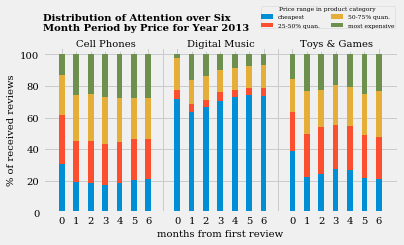

In [67]:
fig, ax = plt.subplots(figsize=(tuple(np.dot(0.5,[11.69,7.69]))))

x_axis = np.arange(len(df_merge2_final['months']))

width_03 = 0.4

p1 = plt.bar(x_axis, df_merge2_final['cheapest'], width=width_03, label='cheapest')
p2 = plt.bar(x_axis, df_merge2_final['25-50% quan.'], width=width_03, bottom=df_merge2_final['cheapest'], label='25-50% quan.')
p3 = plt.bar(x_axis, df_merge2_final['50-75% quan.'], width=width_03, 
             bottom=df_merge2_final['cheapest']+df_merge2_final['25-50% quan.'], label='50-75% quan.')
            
p4 = plt.bar(x_axis, df_merge2_final['most expensive'], width=width_03, 
             bottom=df_merge2_final['cheapest']+df_merge2_final['25-50% quan.']+df_merge2_final['50-75% quan.'], label='most expensive')      

x = np.arange(len(df_merge2_final['cheapest']))    
    
plt.yticks(np.arange(0, 110, 20), fontsize=10)
plt.xticks(x, ['0', '1', '2', '3', '4', '5', '6','', '0', '1', '2', '3', '4', '5', '6','', '0', '1', '2', '3', '4', '5', '6'], fontsize=10)
plt.ylabel('% of received reviews', fontsize=10)
plt.xlabel('months from first review', fontsize=10)

plt.title('Distribution of Attention over Six \nMonth Period by Price for Year 2013\n', weight = 'bold', fontsize=10,loc='left')

plt.text(x = 1, y = 105, s = 'Cell Phones', color = 'black', rotation = 0,
             backgroundcolor = '#f0f0f0', fontsize=10)
         
plt.text(x = 8.7, y = 105, s = 'Digital Music', color = 'black', rotation = 0,
             backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x = 16.5, y = 105, s = 'Toys & Games', color = 'black', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)

plt.legend(loc='upper right', title='Price range in product category', bbox_to_anchor = (1, 1.26),
          ncol=2, borderpad=0, fontsize=6)

plt.rcParams['legend.title_fontsize'] = '4'

# show plot
plt.tight_layout()
plt.savefig('plot3.png')
plt.show()
plt.close()

## Plot 4

### dig dataframe

In [68]:
dig_plt_3 = dig.copy(deep=True)

conditions4_dig = [
    (dig_plt_3['delta_days'] == 0),
    (dig_plt_3['delta_days'] > 0) & (dig_plt_3['delta_days'] <= 30),
    (dig_plt_3['delta_days'] > 30) & (dig_plt_3['delta_days'] <= 60),
    (dig_plt_3['delta_days'] > 60) & (dig_plt_3['delta_days'] <= 90),
    (dig_plt_3['delta_days'] > 90) & (dig_plt_3['delta_days'] <= 120),
    (dig_plt_3['delta_days'] > 120) & (dig_plt_3['delta_days'] <= 150),
    (dig_plt_3['delta_days'] > 150)]

month4_ticks = np.arange(0,7)

dig_plt_3['month'] = np.select(conditions4_dig, month4_ticks, default = 0)

In [69]:
dig_plt_3.loc[:,'reviews']=1
dig_plt_3 = dig_plt_3.loc[(dig_plt_3['year_first_review'] == 2013)]
dig_plt_3 = pd.DataFrame(dig_plt_3.groupby(['product_id', 'month', 'year_first_review']).count()['reviews']).reset_index()
dig_plt_3.head()

,product_id,month,year_first_review,reviews
0,B000000261,0,2013,1
1,B0000006QO,0,2013,1
2,B000001A6R,0,2013,1
3,B000001Z4V,0,2013,1
4,B000002AIK,0,2013,1


In [70]:
dig_plt_3_M0 = dig_plt_3.loc[(dig_plt_3['month'] == 0)]

condition_dig = [(dig_plt_3_M0['reviews'] == 1),
    (dig_plt_3_M0['reviews'] == 2),
    (dig_plt_3_M0['reviews'] == 3),
    (dig_plt_3_M0['reviews'] > 3)]
    #(dig_plt_3_M0['reviews'] == 5),
    #(dig_plt_3_M0['reviews'] == 6),
    #(dig_plt_3_M0['reviews'] == 7),
    #(dig_plt_3_M0['reviews'] == 8),
    #(dig_plt_3_M0['reviews'] == 9),
    #(dig_plt_3_M0['reviews'] == 10),
    #(dig_plt_3_M0['reviews'] > 10)]

rated = np.arange(1,5)

dig_plt_3_M0['reviews_in_M0_range'] = np.select(condition_dig, rated, default = 0) # number of ratings in first month

dig_plt_3_M0 = pd.DataFrame(dig_plt_3_M0)

# check if it is working
dig_plt_3_M0.loc[(dig_plt_3_M0['reviews'] > 8)]
# max number of reviews for dig products in first review date is 6

C:\Users\dsimu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,product_id,month,year_first_review,reviews,reviews_in_M0_range
101455,B00A4EDAN6,0,2013,10,4
102229,B00AA0TZTW,0,2013,25,4
107354,B00B0NU0WO,0,2013,10,4
109237,B00B6LRX5W,0,2013,47,4
109543,B00B7LYJYE,0,2013,11,4
110297,B00BB22GQM,0,2013,16,4
111563,B00BGD0726,0,2013,10,4
115542,B00BYISQTO,0,2013,11,4
118601,B00CEIGXN4,0,2013,12,4
118607,B00CEIGYAG,0,2013,16,4


In [71]:
dig_plt_3_M0 = dig_plt_3_M0.drop(['month', 'year_first_review', 'reviews'], axis=1)

dig_plt_3 = dig_plt_3_M0.merge(dig_plt_3, on='product_id', how='left')

dig_plt_3.head()

# reviews here mean reviews in 'month'
# product 0615583474 had 1 review in month 0 and 6 reviews in month 5

,product_id,reviews_in_M0_range,month,year_first_review,reviews
0,B000000261,1,0,2013,1
1,B0000006QO,1,0,2013,1
2,B000001A6R,1,0,2013,1
3,B000001Z4V,1,0,2013,1
4,B000002AIK,1,0,2013,1


In [72]:
dig_plt_3['reviews in M0_1_range'] = dig_plt_3['reviews_in_M0_range']

In [73]:
dig_plot3_final = pd.DataFrame(dig_plt_3.groupby(['year_first_review', 'month', 'reviews_in_M0_range']).sum()['reviews']).reset_index()
dig_plot3_final.loc[:, 'reviews in M0'] = (pd.DataFrame(dig_plt_3.groupby(['year_first_review', 'month', 'reviews_in_M0_range']).count()['reviews in M0_1_range']).reset_index())['reviews in M0_1_range']
dig_plot3_final.loc[:, 'reviews/reviews_in_M0'] = dig_plot3_final['reviews']/dig_plot3_final['reviews in M0']
dig_plot3_final.loc[:, 'category'] = 'dig'
dig_plot3_final.head(50)

# reviews = reviews in 'month'


,year_first_review,month,reviews_in_M0_range,reviews,reviews in M0,reviews/reviews_in_M0,category
0,2013,0,1,111799,111799,1.000000,dig
1,2013,0,2,868,434,2.000000,dig
2,2013,0,3,213,71,3.000000,dig
3,2013,0,4,630,84,7.500000,dig
4,2013,1,1,12180,6266,1.943824,dig
5,2013,1,2,1370,262,5.229008,dig
6,2013,1,3,626,63,9.936508,dig
7,2013,1,4,2653,80,33.162500,dig
8,2013,2,1,7820,4740,1.649789,dig
9,2013,2,2,562,171,3.286550,dig


### toys dataframe

In [74]:
toys_plt_3 = toys

conditions4_toys = [
    (toys_plt_3['delta_days'] == 0),
    (toys_plt_3['delta_days'] > 0) & (toys_plt_3['delta_days'] <= 30),
    (toys_plt_3['delta_days'] > 30) & (toys_plt_3['delta_days'] <= 60),
    (toys_plt_3['delta_days'] > 60) & (toys_plt_3['delta_days'] <= 90),
    (toys_plt_3['delta_days'] > 90) & (toys_plt_3['delta_days'] <= 120),
    (toys_plt_3['delta_days'] > 120) & (toys_plt_3['delta_days'] <= 150),
    (toys_plt_3['delta_days'] > 150)]

month4_ticks = np.arange(0,7)

toys_plt_3['month'] = np.select(conditions4_toys, month4_ticks, default = 0)

In [75]:
toys_plt_3.loc[:,'reviews']=1
toys_plt_3 = toys_plt_3.loc[(toys_plt_3['year_first_review'] == 2013)]
toys_plt_3 = pd.DataFrame(toys_plt_3.groupby(['product_id', 'month', 'year_first_review']).count()['reviews']).reset_index()

In [76]:
toys_plt_3_M0 = toys_plt_3.loc[(toys_plt_3['month'] == 0)]

condition_toys = [(toys_plt_3_M0['reviews'] == 1),
    (toys_plt_3_M0['reviews'] == 2),
    (toys_plt_3_M0['reviews'] == 3),
    (toys_plt_3_M0['reviews'] > 4)]
    #(toys_plt_3_M0['reviews'] == 5),
    #(toys_plt_3_M0['reviews'] == 6),
    #(toys_plt_3_M0['reviews'] == 7),
    #(toys_plt_3_M0['reviews'] == 8),
    #(toys_plt_3_M0['reviews'] == 9),
    #(toys_plt_3_M0['reviews'] == 10),
    #(toys_plt_3_M0['reviews'] > 10)]

rated = np.arange(1,5)

toys_plt_3_M0['reviews_in_M0_range'] = np.select(condition_toys, rated, default = 0) # number of ratings in first month

toys_plt_3_M0 = pd.DataFrame(toys_plt_3_M0)

# check if it is working
toys_plt_3_M0.loc[(toys_plt_3_M0['reviews'] > 6)]
# max number of reviews for dig products in first review date is 6

C:\Users\dsimu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,product_id,month,year_first_review,reviews,reviews_in_M0_range
32530,B003O6EB70,0,2013,15,4
39389,B004FSE52C,0,2013,7,4
75896,B0088I7L76,0,2013,9,4
77082,B008BV9LK0,0,2013,25,4
106007,B00AXQ9GGA,0,2013,7,4
108984,B00B3YT030,0,2013,9,4
125587,B00CFWWCAW,0,2013,9,4
128132,B00CMQTVUA,0,2013,42,4
132181,B00D3DIMUG,0,2013,76,4
134682,B00DHFOQHI,0,2013,7,4


In [77]:
toys_plt_3_M0 = toys_plt_3_M0.drop(['month', 'year_first_review', 'reviews'], axis=1)

toys_plt_3 = toys_plt_3_M0.merge(toys_plt_3, on='product_id', how='left')

toys_plt_3['reviews in M0_1_range'] = toys_plt_3['reviews_in_M0_range']

In [78]:
toys_plot3_final = pd.DataFrame(toys_plt_3.groupby(['year_first_review', 'month', 'reviews_in_M0_range']).sum()['reviews']).reset_index()
toys_plot3_final.loc[:, 'reviews in M0'] = (pd.DataFrame(toys_plt_3.groupby(['year_first_review', 'month', 'reviews_in_M0_range']).count()['reviews in M0_1_range']).reset_index())['reviews in M0_1_range']
toys_plot3_final.loc[:, 'reviews/reviews_in_M0'] = toys_plot3_final['reviews']/toys_plot3_final['reviews in M0']
toys_plot3_final.loc[:, 'category'] = 'toys'
toys_plot3_final.loc[(toys_plot3_final['year_first_review'] < 2014)]

,year_first_review,month,reviews_in_M0_range,reviews,reviews in M0,reviews/reviews_in_M0,category
0,2013,0,0,44,11,4.000000,toys
1,2013,0,1,94362,94362,1.000000,toys
2,2013,0,2,928,464,2.000000,toys
3,2013,0,3,132,44,3.000000,toys
4,2013,0,4,482,22,21.909091,toys
5,2013,1,0,120,10,12.000000,toys
6,2013,1,1,25298,12749,1.984312,toys
7,2013,1,2,2327,284,8.193662,toys
8,2013,1,3,255,33,7.727273,toys
9,2013,1,4,1415,22,64.318182,toys


### cell dataframe

In [79]:
cell_plt_3 = cell

conditions4_cell = [
    (cell_plt_3['delta_days'] == 0),
    (cell_plt_3['delta_days'] > 0) & (cell_plt_3['delta_days'] <= 30),
    (cell_plt_3['delta_days'] > 30) & (cell_plt_3['delta_days'] <= 60),
    (cell_plt_3['delta_days'] > 60) & (cell_plt_3['delta_days'] <= 90),
    (cell_plt_3['delta_days'] > 90) & (cell_plt_3['delta_days'] <= 120),
    (cell_plt_3['delta_days'] > 120) & (cell_plt_3['delta_days'] <= 150),
    (cell_plt_3['delta_days'] > 150)]

month4_ticks = np.arange(0,7)

cell_plt_3['month'] = np.select(conditions4_cell, month4_ticks, default = 0)

In [81]:
cell_plt_3.loc[:,'reviews']=1
cell_plt_3 = cell_plt_3.loc[(cell_plt_3['year_first_review'] == 2013)]
cell_plt_3 = pd.DataFrame(cell_plt_3.groupby(['product_id', 'month', 'year_first_review']).count()['reviews']).reset_index()

In [82]:
cell_plt_3_M0 = cell_plt_3.loc[(cell_plt_3['month'] == 0)]

condition_cell = [(cell_plt_3_M0['reviews'] == 1),
    (cell_plt_3_M0['reviews'] == 2),
    (cell_plt_3_M0['reviews'] == 3),
    (cell_plt_3_M0['reviews'] > 3)]
    #(cell_plt_3_M0['reviews'] == 5),
    #(cell_plt_3_M0['reviews'] == 6),
    #(cell_plt_3_M0['reviews'] == 7),
    #(cell_plt_3_M0['reviews'] == 8),
    #(cell_plt_3_M0['reviews'] == 9),
    #(cell_plt_3_M0['reviews'] == 10),
    #(cell_plt_3_M0['reviews'] > 10)]

rated = np.arange(1,5)

cell_plt_3_M0['reviews_in_M0_range'] = np.select(condition_cell, rated, default = 0) # number of ratings in first month

cell_plt_3_M0 = pd.DataFrame(cell_plt_3_M0)

# check if it is working
cell_plt_3_M0.loc[(cell_plt_3_M0['reviews'] > 6)]
# max number of reviews for dig products in first review date is 6

C:\Users\dsimu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,product_id,month,year_first_review,reviews,reviews_in_M0_range
70277,B009U6YEY8,0,2013,8,4
90740,B00AH6D8GK,0,2013,15,4
118469,B00B7QGT6U,0,2013,8,4
140650,B00C57OW14,0,2013,22,4
171892,B00D89YKBK,0,2013,13,4
189045,B00E3S148M,0,2013,10,4
191482,B00E9EMEEI,0,2013,8,4


In [83]:
cell_plt_3_M0 = cell_plt_3_M0.drop(['month', 'year_first_review', 'reviews'], axis=1)

cell_plt_3 = cell_plt_3_M0.merge(cell_plt_3, on='product_id', how='left')

cell_plt_3['reviews in M0_1_range'] = cell_plt_3['reviews_in_M0_range']

In [84]:
cell_plot3_final = pd.DataFrame(cell_plt_3.groupby(['year_first_review', 'month', 'reviews_in_M0_range']).sum()['reviews']).reset_index()
cell_plot3_final.loc[:, 'reviews in M0'] = (pd.DataFrame(cell_plt_3.groupby(['year_first_review', 'month', 'reviews_in_M0_range']).count()['reviews in M0_1_range']).reset_index())['reviews in M0_1_range']
cell_plot3_final.loc[:, 'reviews/reviews_in_M0'] = cell_plot3_final['reviews']/cell_plot3_final['reviews in M0']
cell_plot3_final.loc[:, 'category'] = 'cell'
cell_plot3_final.head()

,year_first_review,month,reviews_in_M0_range,reviews,reviews in M0,reviews/reviews_in_M0,category
0,2013,0,1,114147,114147,1.000000,cell
1,2013,0,2,1646,823,2.000000,cell
2,2013,0,3,168,56,3.000000,cell
3,2013,0,4,208,36,5.777778,cell
4,2013,1,1,50810,21674,2.344283,cell


### Merge

In [110]:
plt3_merge = pd.concat([dig_plot3_final, toys_plot3_final, cell_plot3_final], sort='True')
plt3_merge.head()

,category,month,reviews,reviews in M0,reviews/reviews_in_M0,reviews_in_M0_range,year_first_review
0,dig,0,111799,111799,1.000000,1,2013
1,dig,0,868,434,2.000000,2,2013
2,dig,0,213,71,3.000000,3,2013
3,dig,0,630,84,7.500000,4,2013
4,dig,1,12180,6266,1.943824,1,2013


In [111]:
cats = list(df['category'].unique())
mons = list(df['month'].unique())
mons.sort()
conditions_plt3 = []

for i in cats:
    for j in mons:
        cnd = ((plt3_merge['category'] == str(i)) & (plt3_merge['month'] == j))
        conditions_plt3.append(cnd)

months_plt3 = np.arange(0,21)

plt3_merge['months'] = np.select(conditions_plt3, months_plt3, default = 0)

plt3_merge = pd.DataFrame(plt3_merge)

plt3_merge.head(20)

,category,month,reviews,reviews in M0,reviews/reviews_in_M0,reviews_in_M0_range,year_first_review,months
0,dig,0,111799,111799,1.000000,1,2013,7
1,dig,0,868,434,2.000000,2,2013,7
2,dig,0,213,71,3.000000,3,2013,7
3,dig,0,630,84,7.500000,4,2013,7
4,dig,1,12180,6266,1.943824,1,2013,8
5,dig,1,1370,262,5.229008,2,2013,8
6,dig,1,626,63,9.936508,3,2013,8
7,dig,1,2653,80,33.162500,4,2013,8
8,dig,2,7820,4740,1.649789,1,2013,9
9,dig,2,562,171,3.286550,2,2013,9


In [112]:
plt3_merge = plt3_merge.drop(['category', 'month', 'reviews in M0', 'year_first_review'], axis=1)

In [113]:
plot3_1R = plt3_merge.loc[plt3_merge['reviews_in_M0_range'] == 1]
plot3_2R = plt3_merge.loc[plt3_merge['reviews_in_M0_range'] == 2]
plot3_3R = plt3_merge.loc[plt3_merge['reviews_in_M0_range'] == 3]
plot3_4R = plt3_merge.loc[plt3_merge['reviews_in_M0_range'] == 4]

In [114]:
plt3_merge_final = plt3_merge.groupby('months').nunique()['reviews'].reset_index()
plt3_merge_final = plt3_merge_final.merge(plot3_1R, on='months', how='left')
plt3_merge_final = plt3_merge_final.merge(plot3_2R, on='months', how='left')
plt3_merge_final = plt3_merge_final.merge(plot3_3R, on='months', how='left')
plt3_merge_final = plt3_merge_final.merge(plot3_4R, on='months', how='left')
plt3_merge_final = plt3_merge_final.drop(['reviews_x', 'reviews', 'reviews_y'], axis=1)
plt3_merge_final = plt3_merge_final.drop(['reviews_in_M0_range_x', 'reviews_in_M0_range_y'], axis=1)
plt3_merge_final.columns=['months','1 review', '2 reviews', '3 reviews', 'more than 3 reviews']
plt3_merge_final['month'] = [0,1,2,3,4,5,6,0,1,2,3,4,5,6,0,1,2,3,4,5,6]
plt3_merge_final.head(22)

,months,1 review,2 reviews,3 reviews,more than 3 reviews,month
0,0,1.000000,2.000000,3.000000,5.777778,0
1,1,2.344283,6.608133,13.942308,23.937500,1
2,2,2.936276,8.468683,13.595745,33.863636,2
3,3,3.449039,8.043902,13.657895,46.777778,3
4,4,3.571090,7.948424,10.535714,50.250000,4
5,5,3.526256,7.124113,7.714286,46.266667,5
6,6,3.673408,7.659751,7.421053,38.923077,6
7,7,1.000000,2.000000,3.000000,7.500000,0
8,8,1.943824,5.229008,9.936508,33.162500,1
9,9,1.649789,3.286550,5.478261,16.410714,2


### Plots

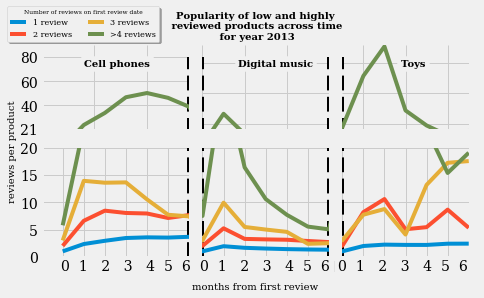

In [115]:
style.use('fivethirtyeight')

fig = plt.figure(figsize=(15,8))

#plt.subplot(2,2,1)

#plt.subplot(2,2,2)

#plt.subplot(2,2,3)

sps1, sps2, sps3, sps4 = GridSpec(2,2)

#bax = brokenaxes(xlims=((.1, .3),(.7, .8)), subplot_spec=sps1)

bax = brokenaxes(xlims=((0, 7), (8, 14), (15, 21)), ylims=((0,20), (21,90)),  height_ratios=[1, 1.3], wspace=00.1, d = 0, yscale=10, subplot_spec=sps1)
bax.plot(np.arange(1,22,1), plt3_merge_final['1 review'], label='1 review')
bax.plot(np.arange(1,22,1), plt3_merge_final['2 reviews'], label = '2 reviews')
bax.plot(np.arange(1,22,1), plt3_merge_final['3 reviews'], label = '3 reviews')
bax.plot(np.arange(1,22,1), plt3_merge_final['more than 3 reviews'], label = '>4 reviews')

bax.vlines(7,0,80,color = 'k', linestyles = 'dashed')
bax.vlines(8,0,80,color = 'k', linestyles = 'dashed')
bax.vlines(14,0,80,color = 'k', linestyles = 'dashed')
bax.vlines(15,0,80,color = 'k', linestyles = 'dashed')


plt.text(x = 0.1, y = 0.9, s='Cell phones', color = 'black', weight = 'bold', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)
plt.text(x = 0.46, y = 0.9, s='Digital music', color = 'black', weight = 'bold', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)
plt.text(x = 0.84, y = 0.9, s='Toys', color = 'black', weight = 'bold', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=1.0, y=-0.065, s=' ', 
        color='black', backgroundcolor = '#f0f0f0')

plt.text(x=0.045, y=-0.065, s='0  1   2   3   4  5  6', 
         color='black', backgroundcolor = '#f0f0f0')

plt.text(x=0.37, y=-0.065, s='0  1   2   3   4  5  6', 
         color='black', backgroundcolor = '#f0f0f0')

plt.text(x=0.695, y=-0.065, s='0  1   2   3   4  5  6', 
         color='black', backgroundcolor = '#f0f0f0')

bax.first_col[1].set_yticks([0, 5, 10, 15, 20])
bax.first_col[0].set_yticks([21, 40, 60, 80])

bax.last_row[0].set_xticks([1, 2, 3, 4, 5, 6, 7])
bax.last_row[1].set_xticks([8, 9, 10, 11, 12, 13, 14])
bax.last_row[2].set_xticks([15, 16, 17, 18, 19, 20, 21])
    
bax.legend(loc='upper left', bbox_to_anchor=(-0.09, 1.2), title = 'Number of reviews on first review date', 
           ncol=2, fancybox=True, shadow=True, fontsize=8)
bax.set_xlabel("months from first review", labelpad = 0, fontsize=10)
bax.set_ylabel("reviews per product", labelpad = 25, fontsize=10)
bax.set_title('Popularity of low and highly\n reviewed products across time\n for year 2013', weight='bold', fontsize=10)

plt.show()

## Plots

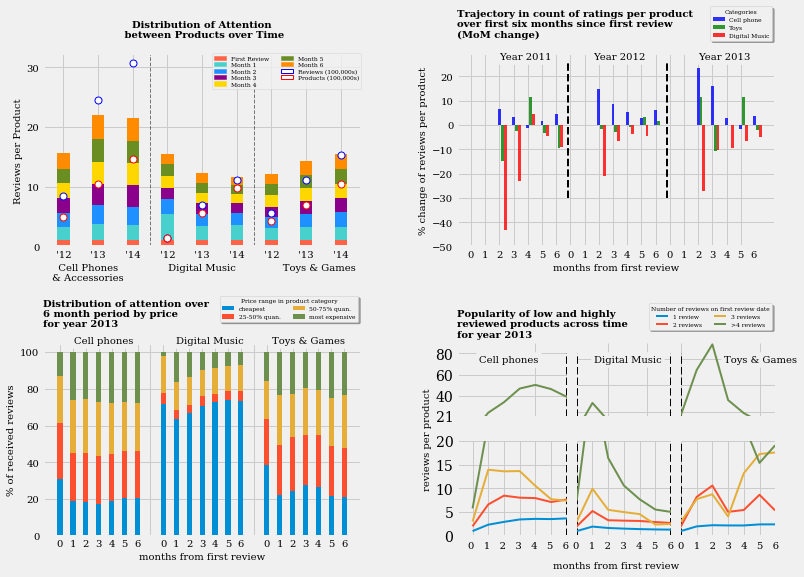

In [116]:
style.use('fivethirtyeight')

plt.figure(figsize=(11.69,8.27))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

sps1, sps2, sps3, sps4 = GridSpec(2,2)

plt.subplot(2,2,1)


N = np.dot([df1['category'].nunique()],[df1['year_first_review'].nunique()])    # N = number of categories = 3 categories over 3 years
M = df1['month'].nunique()    # M = number of months from first review
categories = list(df['category'].unique())    # categories = unique product categories

# reviews/product per month data
monthcat = []     # list of values for each month as a categorical variable
for i in np.arange(M):
    for j in categories:
        for z in np.arange(2011,2014):
            m = np.array([(df1[(df1['category']==j) & (df1['month']==i) & (df1['year_first_review']==z)]['reviews/product'].values)])
            monthcat.append(m)
monthcat = np.concatenate(monthcat)
monthcat.resize(7,9)

# plot params
ind = np.arange(N)    # the x locations for the groups
w = 0.35       # the width of the bars: can also be len(x) sequence
bottom = 0     # null bottom bar
colors = ['tomato','mediumturquoise','dodgerblue','darkmagenta','gold','olivedrab','darkorange']

#plotting average reviews per product
for i in np.arange(M):
    if i == 0:
        plt.bar(ind, monthcat[0], width=w, color=colors[i])
    else:
        bottom+= monthcat[i-1]
        plt.bar(ind, monthcat[i], width=w, color=colors[i],
             bottom=bottom)

# font params
rcParams['font.family'] = 'serif'
font_ax = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 10,
        }
font_t = {'family': 'serif',
        'color':  'k',
        'weight': 'bold',
        'size': 12,
        }
# title, labels, ticks
plt.axvline(x=2.5, ymin=0, ymax=22, linestyle='--', linewidth=1, color='k', alpha=0.5)
plt.axvline(x=5.5, ymin=0, ymax=22, linestyle='--', linewidth=1, color='k', alpha=0.5)

plt.ylabel('Reviews per Product', fontdict=font_ax, fontsize=10)
plt.xlabel('   Cell Phones                Digital Music               Toys & Games\n& Accessories                                                                         ', fontdict=font_ax, fontsize=10)
plt.title('Distribution of Attention\n between Products over Time\n', fontdict=font_t, fontsize=10)

xticks = ['\'12','\'13','\'14']*3
plt.xticks(ind,xticks, fontsize=10)
plt.setp(ax1.get_yticklabels(), fontsize=10, family='serif')
plt.setp(ax1.get_xticklabels(), fontsize=10, family='serif')
plt.yticks(list(np.arange(0, 26, 2)),fontsize=10)

# year total data
ax2 = ax1.twinx()
ax2.set_ylabel('Total Reviews, Total Products (100ths)', fontdict=font_ax, rotation=270, labelpad=12, fontsize=10)
ax2.grid(b=False)
plt.setp(ax2.get_yticklabels(), fontsize=10, family='serif')
plt.yscale('linear')

#total reviews count
ylist1 = []
for i in categories:
    for j in np.arange(2011,2014):
        y = (df1[(df1['category']==i) & (df1['year_first_review']==j)]['year_total_reviews'].aggregate(np.sum).round(3))
        ylist1.append(y)
plt.plot(ind,ylist1,linewidth=0,marker='o',markersize=7, markeredgecolor='b',color='w')

# total products count
ylist2 = []
for i in categories:
    for j in np.arange(2011,2014):
        y = (df1[(df1['category']==i) & (df1['year_first_review']==j)]['year_total_products'].aggregate(np.sum).round(3))
        ylist2.append(y)
plt.plot(ind,ylist2,linewidth=0,marker='o',markersize=7, markeredgecolor='r',color='w')

# legend params
patchlist=[]
for i in np.arange(M):
    if i == 0:
        patch=mpatches.Patch(color=colors[i], label=('First Review'))
        patchlist.append(patch)
    else:
        patch=mpatches.Patch(color=colors[i], label=(str('Month ')+str(i)))
        patchlist.append(patch)
c1 = mpatches.Circle((0.5, 0.5), 0.25, label='Reviews (100,000s)', facecolor='w',
                    edgecolor='b', linewidth=1)
patchlist.append(c1)
c2 = mpatches.Circle((0.5, 0.5), 0.25, label='Products (100,000s)', facecolor='w',
                    edgecolor='r', linewidth=1)
patchlist.append(c2)
plt.legend(handles=patchlist, ncol=2, borderaxespad=0, fontsize=6, labelspacing=0.2)

# Plot 2
plt.subplot(2,2,2)

index = np.arange(1,22,1)
bar_width = 0.2
bar_width1 = 0.4
opacity = 0.8

plt.vlines(7.8,-30,26,color = 'k', linestyles = 'dashed', linewidth=2)
plt.vlines(14.8,-30,26,color = 'k', linestyles = 'dashed', linewidth=2)

plt.bar(index, df_plt1_final['% change cell'], bar_width,
alpha=opacity,
color='b',
label='Cell phone')

plt.bar(index + bar_width, df_plt1_final['% change toys'], bar_width,
alpha=opacity,
color='g',
label='Toys')

plt.bar(index + bar_width1, df_plt1_final['% change dig'], bar_width,
alpha=opacity,
color='r',
label='Digital Music')

x = np.arange(len(df_plt1_final['month']))

plt.xticks(x, ['', '0', '1', '2', '3', '4', '5', '6', '0', '1', '2', '3', '4', '5', '6', '0', '1', '2', '3', '4', '5', '6'], fontsize=10)
plt.yticks(np.arange(-50,20.1,10), fontsize=10)
plt.legend(loc='upper right', title = 'Categories', bbox_to_anchor = (1, 1.26), fancybox=True, shadow=True, fontsize=6)
plt.xlabel('months from first review', fontsize=10)
plt.ylabel("% change of reviews per product", fontsize=10)
plt.title('Trajectory in count of ratings per product\nover first six months since first review\n(MoM change)\n', weight='bold', fontsize=10,loc='left')

plt.text(x=20.65, y=-54.25, s='6', 
        color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=3, y=27, s='Year 2011', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=9.6, y=27, s='Year 2012', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=17, y=27, s='Year 2013', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.rcParams['legend.title_fontsize'] = '6'

# Plot 3
plt.subplot(2,2,3)

x_axis = np.arange(len(df_merge2_final['months']))

width_03 = 0.4

p1 = plt.bar(x_axis, df_merge2_final['cheapest'], width=width_03, label='cheapest')
p2 = plt.bar(x_axis, df_merge2_final['25-50% quan.'], width=width_03, bottom=df_merge2_final['cheapest'], label='25-50% quan.')
p3 = plt.bar(x_axis, df_merge2_final['50-75% quan.'], width=width_03, 
             bottom=df_merge2_final['cheapest']+df_merge2_final['25-50% quan.'], label='50-75% quan.')
            
p4 = plt.bar(x_axis, df_merge2_final['most expensive'], width=width_03, 
             bottom=df_merge2_final['cheapest']+df_merge2_final['25-50% quan.']+df_merge2_final['50-75% quan.'], label='most expensive')
             

x = np.arange(len(df_merge2_final['cheapest']))    
    
plt.yticks(np.arange(0, 110, 20), fontsize=10)
plt.xticks(x, ['0', '1', '2', '3', '4', '5', '6','', '0', '1', '2', '3', '4', '5', '6','', '0', '1', '2', '3', '4', '5', '6'], fontsize=10)
plt.ylabel('% of received reviews', fontsize=10)
plt.xlabel('months from first review', fontsize=10)

plt.title('Distribution of attention over\n6 month period by price\nfor year 2013\n', weight = 'bold', fontsize=10,loc='left')


plt.text(x = 1.1, y = 105, s = 'Cell phones', color = 'black', rotation = 0,
             backgroundcolor = '#f0f0f0', fontsize=10)
         
plt.text(x = 9.0, y = 105, s = 'Digital Music', color = 'black', rotation = 0,
             backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x = 16.4, y = 105, s = 'Toys & Games', color = 'black', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)

plt.legend(loc='upper right', title='Price range in product category', bbox_to_anchor = (1, 1.26),
          ncol=2, fancybox=True, shadow=True, fontsize=6)

plt.rcParams['legend.title_fontsize'] = '6'

# plot 4
bax = brokenaxes(xlims=((0, 7), (8, 14), (15, 21)), ylims=((0,20), (21,90)),  height_ratios=[1, 1.3], wspace=0.1, hspace=0.3, d = 0, yscale=10, subplot_spec=sps4)
bax.plot(np.arange(1,22,1), plt3_merge_final['1 review'], label='1 review', linewidth=2)
bax.plot(np.arange(1,22,1), plt3_merge_final['2 reviews'], label = '2 reviews', linewidth=2)
bax.plot(np.arange(1,22,1), plt3_merge_final['3 reviews'], label = '3 reviews', linewidth=2)
bax.plot(np.arange(1,22,1), plt3_merge_final['more than 3 reviews'], label = '>4 reviews', linewidth=2)

bax.vlines(7,0,80,color = 'k', linestyles = 'dashed', linewidth=2)
bax.vlines(8,0,80,color = 'k', linestyles = 'dashed', linewidth=2)
bax.vlines(14,0,80,color = 'k', linestyles = 'dashed', linewidth=2)
bax.vlines(15,0,80,color = 'k', linestyles = 'dashed', linewidth=2)


plt.text(x = 0.07, y = 0.9, s='Cell phones', color = 'black', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)
plt.text(x = 0.43, y = 0.9, s='Digital Music', color = 'black', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)
plt.text(x = 0.84, y = 0.9, s='Toys & Games', color = 'black', rotation = 0, 
             backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=1.0, y=-0.065, s=' ', 
        color='black', backgroundcolor = '#f0f0f0')

plt.text(x=0.035, y=-0.065, s='0   1   2   3   4   5   6', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=0.365, y=-0.065, s='0   1   2   3   4   5   6', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

plt.text(x=0.695, y=-0.065, s='0   1   2   3   4   5   6', 
         color='black', backgroundcolor = '#f0f0f0', fontsize=10)

bax.first_col[1].set_yticks([0, 5, 10, 15, 20])
bax.first_col[0].set_yticks([21, 40, 60, 80])

bax.last_row[0].set_xticks([1, 2, 3, 4, 5, 6, 7])
bax.last_row[1].set_xticks([8, 9, 10, 11, 12, 13, 14])
bax.last_row[2].set_xticks([15, 16, 17, 18, 19, 20, 21])
    
bax.legend(loc='upper right', title = 'Number of reviews on first review date', bbox_to_anchor = (1, 1.22),
           ncol=2, fancybox=True, shadow=True, fontsize=6)
bax.set_xlabel("months from first review", labelpad = -10, fontsize=10)
bax.set_ylabel("reviews per product", labelpad = 25, fontsize=10)
bax.set_title('Popularity of low and highly\nreviewed products across time\nfor year 2013', weight='bold', fontsize=10,loc='left')

plt.savefig('plot1.png')
plt.show()